# Part 3: Recognition

In this part of the assignment, you will implement and train neural networks, including convolutional neural networks, for an image recognition task using PyTorch. Specifically, we will classify a number of grayscale images of pieces of clothing by predicting a label for the name of the clothing type.

**Learning objectives.** You will:
1. Define multilayer perceptrons and convolutional neural networks using PyTorch
2. Optimize neural networks using automatic differentation and minibatch stochastic gradient descent in PyTorch
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

While it is possible to complete this task using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

In [2]:
# Run but DO NOT MODIFY this code

# Import modules
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Load Fashion MNIST datasets
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

The following code then visualizes some random examples of the training data.

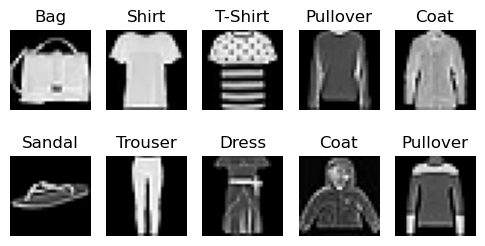

In [3]:
# Run but DO NOT MODIFY this code

# Visualize Random Examples
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

from matplotlib import pyplot as plt

figure = plt.figure(figsize=(6, 3))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Task 1

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a multilayer perceptron to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least at least two [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to connect between the input, hidden units, and an output units. You should use nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) at least for the hidden units. You may optionally include additional layers but are not required to do so.

Your model should not be excessively large beyond what is necessary to accomplish good performance (see the next task). After your code, briefly explain the architecture of your model including a discussion of the hidden layers and the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [7]:
import torch
from torch import nn

class MLP(torch.nn.Module):
    """Definition of a multilayer perceptron for classification in Pytorch."""
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),   # First hidden layer with 64 neurons
            nn.ReLU(),
            nn.Linear(64, 10),      # Output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = MLP()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 50890


The input layer has an input size of 28x28 (the input size of the images derived from FashionMNIST dataset), which gets flattened into a vector of size 784.
The single linear layer then takes 784 input features and outputs 64 features representing the hidden units. This is followed by a ReLU activation function to transform the linear function to a non-linear activiation function, used to learning the complex relationships between the features. We picked 64 hidden units because it allowed us to avoid excessive overfitting with too many hidden units and under the parameter count while still delivering a satisfactory fit. After the RELU activation, the output layer reduces the 64 hidden units to 10 output classes, which are the 10 grayscale images of the pieces of clothing.

Parameter Calculation:
First Linear Layer: (28x28) * 64  + 64 = 50240
Output Layer: (64 * 10) + 10 = 650 (weights + biases)
Total parameters = 50240 + 650 = 50890

## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

You should be able to achieve a validation accuracy of 83% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 1 if so) or the training hyperparameters to accomplish this. 

When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data. Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [6]:
# Write code for task 2 here
from torch import nn, optim
from torchvision.transforms import ToTensor

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) 

num_epochs = 10  
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        
        #back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    
    #val accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            logits = model(X_val)
            _, predicted = torch.max(logits, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()
    
    val_accuracy = correct / total * 100  
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

#test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        logits = model(X_test)
        _, predicted = torch.max(logits, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

test_accuracy = correct / total * 100  
print(f"Test Accuracy: {test_accuracy:.2f}%")

NameError: name 'MLP' is not defined

The main hyperparameters we used were the parameters defined in the previous MLP. Our choice of 10 epochs and a learning rate of 0.01 controls the step size during gradient descent. We set the learning rate to 0.01 because it was the defualt given in the documentation and it did not lead to overfitting or reduced performance based in the data given and observed runtime.
This justification also holds for our use of 10 epochs, because it was an easily conceviable round number and achieved satisfactory performance and accuracy standards.

## Task 3

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a convolutional neural network to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least one [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), at least one [pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), and at least one fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), though you may choose to use a deeper model with additional layers to achieve good performance.

Your model should not be excessively large beyond what is necessary to accomplish good performance. After your code, briefly explain the architecture of your model including a discussion of all of the hidden layers including choice of any parameters such as kernels or strides, as well as the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [4]:
import torch
from torch import nn
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(5, 5), stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=15, kernel_size=(3, 3), stride=1, padding='same')

        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        self.flatten = nn.Flatten()
        
        self.h = nn.Linear(in_features=7*7*15, out_features=100)
        self.o = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.h(x))
        x = self.o(x)
        
        return x
    
model = ConvNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 75430


We used GPT to resolve an issue resulting from trying to use the Sigmoid() function. After reporting the error after mutliple rounds of attempted debugging, GPT advised us to utilize the flatten method instead which resolved our issue.

## Task 4

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). 

Instead of using printouts to monitor training, use the more professional PyTorch `Tensorboard` utility as [described in the tutorial documentation here](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html). Log the (a) training loss, (b) validation loss, and (c) validation accuracy over the course of training using `Tensorboard` (you likely only want to compute validation accuracy once per epoch, but you can log the loss more often if you wish). For your final training run, report the visualizations created by Tensorboard. You can export the visualizations from Tensorboard by selecting "SCALARs" (upper left), "Show data download links", and "Download" under each image, or you can just take screenshots. You can [add images using markdown as shown in the documentation](https://www.markdownguide.org/cheat-sheet/#basic-syntax).

You should be able to achieve a validation accuracy of 88% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 3 if so) or the training hyperparameters to accomplish this. In particular, you should demonstrate improved performance (while still using fewer than 100,000 parameters) compared to your previous multilayer perceptron. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [8]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch import optim

model = ConvNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

writer = SummaryWriter('runs/convNN_experiment')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

num_epochs = 10  

for epoch in range(num_epochs):
    model.train() 
    total_train_loss = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)

    avg_train_loss = total_train_loss / len(train_loader)
    
    # Validation step
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            logits = model(X_val)
            val_loss = loss_fn(logits, y_val)
            total_val_loss += val_loss.item()

            _, predicted = torch.max(logits, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_accuracy = correct / total * 100
    avg_val_loss = total_val_loss / len(val_loader)

    writer.add_scalar('Validation Loss', avg_val_loss, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
writer.flush()
writer.close()

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in val_loader: 
        logits = model(X_test)
        _, predicted = torch.max(logits, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

test_accuracy = correct / total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


KeyboardInterrupt: 

In [14]:
tensorboard --logdir=runs

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3224537314.py, line 1)

In our code for training the convolutional neural network, we set several key hyperparameters: the learning rate is 0.01, which determines the initial step size for the optimizer; momentum is set to 0.9 to accelerate the training process by smoothing out updates based on past gradients. Furthermore, the model is trained for 10 epochs, and the batch size is defined by the train_loader and val_loader, though not explicitly stated. The data is also normalized to have a mean and standard deviation of 0.5 for consistent scaling. We log the training loss every 100 batches to ensure we still get insights into the training process while optimizing resource efficiency.

We prompted GPT to help structure the batching process correctly, especially when implementing the mini-batch gradient descent in the training loop and ensuring smooth integration with TensorBoard for tracking metrics. Furthermore, we used GPT to understand the process of setting up transformations like normalization and tensor conversion for input data, ensuring that the data pipeline aligned with the model's needs.